# Extracting temperature at specific reefs
**Authors**: Leo Ghignone, Denisse Fierro Arcos  
  
This notebook demonstrates direct access to the [AIMS Temperature Logger Monitoring Program](https://apps.aims.gov.au/metadata/view/4a12a8c0-c573-11dc-b99b-00008a07204e) dataset in the RIMReP `geoparquet` collection. This dataset includes sea temperature data from 1980 for tropical and subtropical coral reefs around Australia, and it includes sites within the Great Barrier Reef.   
  
In this example, we will extract the coordinates for all sites sampled in this monitoring program and then extract the temperature data for a specific site of interest. This means that we will not need to know the exact location of the site, but we will need to know the name of the site of our interest. 
  
**Note:** The `geoparquet` collection is a compilation of datasets that have been converted to the Apache `parquet` format. This format is designed for efficient storage and retrieval of tabular data. The `geoparquet` collection is stored on the RIMReP S3 bucket and is accessible to all users.

## Loading libraries

In [1]:
# Accessing S3 bucket
from pyarrow import parquet as pq
# Manipulating dataframes
import pandas as pd
# Checking patterns in strings using regular expressions (regex)
import re
# Load and manipulate geospatial data
import dask_geopandas
import geopandas as gpd
# Plotting
import matplotlib.pyplot as plt
#Color maps
from matplotlib import colormaps as cmaps
# Mapping
import cartopy.crs as ccrs
import cartopy.feature as cf

## Inspecting metadata
The AIMS Temperature dataset contains over 150 million records. We will use its metadata to check the structure of the dataset and to determine the best way to access the data.

In [2]:
#Connecting to metadata file
md = pq.read_metadata(f"s3://rimrep-data-public/091-aims-sst/test-50-64-spatialpart/_metadata")
#Checking contents
md

  created_by: parquet-cpp-arrow version 10.0.1
  num_columns: 23
  num_rows: 150663521
  num_row_groups: 50
  format_version: 2.6
  serialized_size: 155051

The metadata is telling us that the AIMS temperature dataset contains 23 columns and over 150 million rows, and it is made up of 50 different files.  
  
We can check the structure of the data by calling its `schema` attribute. This will return a list containing the name of the column and its data type.

In [3]:
md.schema

required group field_id=-1 schema {
  optional int64 field_id=-1 fid;
  optional int64 field_id=-1 deployment_id;
  optional binary field_id=-1 site (String);
  optional int64 field_id=-1 site_id;
  optional binary field_id=-1 subsite (String);
  optional int64 field_id=-1 subsite_id;
  optional int64 field_id=-1 from_date (Timestamp(isAdjustedToUTC=false, timeUnit=microseconds, is_from_converted_type=false, force_set_converted_type=false));
  optional int64 field_id=-1 thru_date (Timestamp(isAdjustedToUTC=false, timeUnit=microseconds, is_from_converted_type=false, force_set_converted_type=false));
  optional double field_id=-1 depth;
  optional binary field_id=-1 parameter (String);
  optional binary field_id=-1 instrument_type (String);
  optional binary field_id=-1 serial_num (String);
  optional double field_id=-1 lat;
  optional double field_id=-1 lon;
  optional binary field_id=-1 gbrmpa_reef_id (String);
  optional binary field_id=-1 metadata_uuid (String);
  optional double fie

The `schema` tells us that the dataset contains 23 columns, which matches the information we got from the metadata. It also tells us that the data types are either `string` or `double`.  
  
We can also obtain more details about a specific column, by calling the `column` method and passing the name of the column as an argument as shown below.

In [4]:
md.schema.column(19)

<ParquetColumnSchema>
  name: qc_val
  path: qc_val
  max_definition_level: 1
  max_repetition_level: 0
  physical_type: DOUBLE
  logical_type: None
  converted_type (legacy): NONE

If we refer to the original site for the [AIMS Temperature Logger Monitoring Program](https://apps.aims.gov.au/metadata/view/4a12a8c0-c573-11dc-b99b-00008a07204e), we can see that the `qc_val` column refers to the quality controlled temperature obtained from the loggers deployed as part of this program.

## Connecting to S3 parquet directory
We will connect to the S3 bucket containing the AIMS Temperature dataset using the `dask_geopandas` library. We will only keep sites that have been deployed in the Great Barrier Reef Marine Protected Area (GBRMPA), so we will provide a `filter` that contains the minimum and maximum coordinates (i.e., `lat` and `lon`) of a bounding box around the Great Barrier Reef Marine Protected Area.

As we saw above, this dataset includes 23 columns, but we will only select a few that contain information that is interesting to us:
- `site`: name of site where temperature logger was deployed,
- `subsite`: contains a shorten version of the site name and an indication of where loggers where deployed (see below for more details),
- `geometry`: includes latitude and longitude coordinates in [well-known binary (WKB)](https://loc.gov/preservation/digital/formats/fdd/fdd000549.shtml) format  
  
Based on the `subsite` information, we will create a new column that we will call `deployment_location`. If the `subsite` string in a row includes `SL` it indicates that the temperature logger was deployed on a reef slope (depths of 3 m or more). Thus, our new column will be labelled reef slope. If a row contains `FL` in the `subsite` column, this means the temperature logger was deployed on a reef flat (areas less than 3 m deep). Therefore, we will classify this observation as reef flat in our new column.

Note that when we use the `dask_geopandas` library, the `geometry` field is automatically recognised as coordinates in decimal degrees and used as the `geometry` column in a `geopandas` `GeoDataFrame` object. This means we can use it to plot the data in a map easily.

The following code chunk may take a few minutes to run, as it is loading over 150 million records.

In [2]:
# Creating maximum and minimum coordinates for bounding box around the GBRMPA
filter = [('lon', '>=', 140.5),
          ('lat', '>=', -28.5),
          ('lon', '<=', 156.0),
          ('lat', '<=', -6.5)]

# Connecting to the S3 bucket where the AIMS temperature data is stored
dask_geo_df = dask_geopandas.read_parquet("s3://rimrep-data-public/091-aims-sst/test-50-64-spatialpart/", 
                                          #Applying initial bounding box filter
                                          filters = [filter], 
                                          #Specifying which columns to read
                                          columns = ['site', 'subsite', 'geometry'],
                                          #Specifying the column to be used as index
                                          index = 'fid',
                                          #Connecting anonimously as no authentication is needed for this s3 bucket (it is public)
                                          storage_options = {"anon": True}) 

# Keeping unique values
dask_geo_df = dask_geo_df.drop_duplicates()

# Transforming to pandas dataframe
sites = dask_geo_df.compute()

# Checking the contents of the dataframe - First five rows
sites.head()

,site,subsite,geometry
fid,,,
149842221,Karumba,KURSL1,POINT (140.83020 -17.49350)
149696096,Karumba,KURFL1,POINT (140.83020 -17.49350)
149519190,Night Island,NIGFL1,POINT (143.58030 -13.16910)
149501081,Night Island,NIGSL1,POINT (143.58030 -13.16900)
53983161,Curd Reef,CURDFL1,POINT (143.51120 -12.58530)


## Creating `deployment_location` column
We will use the `subsite` column to create the deployment categories as explained in the section above. If no condition is met, then we will label the row as other.

In [3]:
# Creating new column with deployment location information
sites['deployment_location'] = sites.apply(lambda x: 'reef slope' if bool(re.match('.*(SL[0-9]{1,2})', x.subsite)) == True \
         else ('reef flat' if bool(re.match('.*(FL[0-9]{1,2})', x.subsite)) == True else 'other'), axis = 1)

#Checking results
sites

,site,subsite,geometry,deployment_location
fid,,,,
149842221,Karumba,KURSL1,POINT (140.83020 -17.49350),reef slope
149696096,Karumba,KURFL1,POINT (140.83020 -17.49350),reef flat
149519190,Night Island,NIGFL1,POINT (143.58030 -13.16910),reef flat
149501081,Night Island,NIGSL1,POINT (143.58030 -13.16900),reef slope
53983161,Curd Reef,CURDFL1,POINT (143.51120 -12.58530),reef flat
...,...,...,...,...
6613340,Nelly Bay,NELFL1,POINT (146.84750 -19.17150),reef flat
11189188,Middle Reef,MIRSL2,POINT (146.81020 -19.19450),reef slope
146728532,Middle Reef,MIRSL1,POINT (146.82090 -19.20110),reef slope


## Mapping sites
From the summary table we created in the previous step, we will make a map with the location of all deployment sites within the GBRMPA bounding box. We will also highlight the location of two sites: **Hayman Island** and **Heron Island** in red. We will use these two sites as examples on how to extract data from sites of interest. 

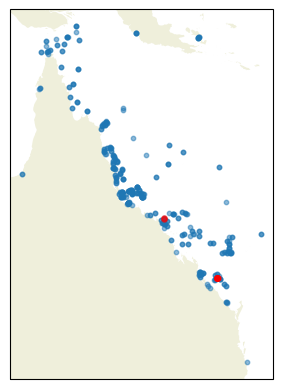

In [72]:
#Initiliasing the figure
fig = plt.figure()

#Adding a plot to the figure and assigning projection
ax = plt.axes(projection = ccrs.PlateCarree())

#Plotting the data using a scatter plot
sites.plot(ax = ax, alpha = 0.5, markersize = 10)

#Plotting sites of interest in red
sites[(sites.site == 'Heron Island') | (sites.site == 'Hayman Island')].plot(ax = ax, color = 'red',
                                                                    alpha = 0.5, markersize = 15)

#Adding a basemap of land areas
ax.add_feature(cf.LAND)

## Extracting data for sites of interest
We can use the information in our `sites` variable to extract data for a site of interest. All we need to know is the name of the site, as shown below.

Here, we will use data collected at **Hayman Island** and **Heron Island** as an example. We will calculate monthly means at each site, so we can plot time series that will show us how temperature has changed over time.

In [4]:
# First, we get the coordinates for the sites of interest
sites_coords = sites[(sites.site == 'Heron Island') | (sites.site == 'Hayman Island')]

# We then get a bounding box around the sites of interest to apply an initial filter to the AIMS dataset
minx = sites_coords.bounds.minx.min()
miny = sites_coords.bounds.miny.min()
maxx = sites_coords.bounds.maxx.max()
maxy = sites_coords.bounds.maxy.max()


Applying initial filter to dataset. This will reduce the number of rows that we need to load into memory, and it will make the subsetting the data faster.

In [5]:
# Creating maximum and minimum coordinates for bounding box around the GBRMPA
filter = [('lon', '>=', minx),
          ('lat', '>=', miny),
          ('lon', '<=', maxx),
          ('lat', '<=', maxy)]

# Connecting to the S3 bucket where the AIMS temperature data is stored
dask_geo_df = dask_geopandas.read_parquet("s3://rimrep-data-public/091-aims-sst/test-50-64-spatialpart/", 
                                          #Applying initial bounding box filter
                                          filters = [filter], 
                                          #Specifying which columns to read
                                          columns = ['site', 'geometry', 'qc_val', 'time'],
                                          #Specifying the column to be used as index
                                          index = 'fid',
                                          #Connecting anonimously as no authentication is needed for this s3 bucket (it is public)
                                          storage_options = {"anon": True}) 

# Transforming to pandas dataframe
sites_temp = dask_geo_df.compute()

Now we will only keep the observations that match the coordinates of our sites of interest by performing a spatial join using `geopandas`.

In [12]:
# Applying spatial join
sites_temp = gpd.sjoin(sites_coords, sites_temp, how = 'inner')

# Checking results
sites_temp.head()

,site_left,subsite,geometry,deployment_location,index_right,site_right,qc_val,time
fid,,,,,,,,
135323357,Heron Island,HERFL5,POINT (151.91840 -23.44480),reef flat,135292342,Heron Island,27.41,1998-01-05 08:30:00+00:00
135323357,Heron Island,HERFL5,POINT (151.91840 -23.44480),reef flat,135292343,Heron Island,26.94,1998-01-05 09:00:00+00:00
135323357,Heron Island,HERFL5,POINT (151.91840 -23.44480),reef flat,135292344,Heron Island,26.74,1998-01-05 09:30:00+00:00
135323357,Heron Island,HERFL5,POINT (151.91840 -23.44480),reef flat,135292345,Heron Island,26.63,1998-01-05 10:00:00+00:00
135323357,Heron Island,HERFL5,POINT (151.91840 -23.44480),reef flat,135292346,Heron Island,26.37,1998-01-05 10:30:00+00:00


We can see that there are two columns with site names. Next, we will check only the sites of interest have been included and that the `site_left` and `site_right` columns contain the same data.

In [13]:
# Comparing that the site names columns are the same. If the sites do not match, the sum of all values will be larger than 0
sum(sites_temp.site_left != sites_temp.site_right)

0

Now we can check the unique names match our sites of interest.

In [15]:
sites_temp.site_right.unique()

array(['Heron Island', 'Hayman Island'], dtype=object)

The data frame does only include observations for the sites of our interest. This means we can remove and the columns labelled as "right" from our data frame because they contain the same information as the "left" columns.  
  
We will also calculate the mean monthly temperature at each site and deployment location combination.

In [94]:
# Removing columns that are not needed 
sites_temp.drop(columns = ['index_right', 'site_right'], inplace = True)

# Renaming site column
sites_temp.rename(columns = {'site_left': 'site'}, inplace = True)

# Extracting the year and month for each observation
sites_temp['year'] = sites_temp.time.dt.year.values
sites_temp['month'] = sites_temp.time.dt.month.values
# Ensuring months are two digits - This wil be important for labelling our plots later
sites_temp['month'] = sites_temp.apply(lambda x: str(x.month).zfill(2), axis = 1)

# Calculate mean monthly temperatures for each site and deployment location
sites_temp = sites_temp.groupby(['site', 'deployment_location', 'year', 'month']).mean('qc_val').reset_index()

#Checking results
sites_temp.head()

,site,deployment_location,year,month,qc_val,date_mean,col
0,Hayman Island,reef flat,1996,05,25.171466,1996-05-01,0
1,Hayman Island,reef flat,1996,06,24.397491,1996-06-01,0
2,Hayman Island,reef flat,1996,07,23.204402,1996-07-01,0
3,Hayman Island,reef flat,1996,08,22.742272,1996-08-01,0
4,Hayman Island,reef flat,1996,09,23.614451,1996-09-01,0


### Plotting monthly means
Before plotting, we will add a few extra columns that we will use to label and color our plot.

In [113]:
# Adding column with dates for which means were calculated
sites_temp['date_mean'] = pd.to_datetime(sites_temp.year.astype('str') + '-' + sites_temp.month)

# Transforming site column to categorical data
sites_temp['site'] = pd.Categorical(sites_temp.site)

# Changing site categories to numeric values for plotting - We can then change the colors based on this column
sites_temp['colours'] = sites_temp.site.cat.codes

#Checking results
sites_temp.head()

,site,deployment_location,year,month,qc_val,date_mean,colours
0,Hayman Island,reef flat,1996,05,25.171466,1996-05-01,0
1,Hayman Island,reef flat,1996,06,24.397491,1996-06-01,0
2,Hayman Island,reef flat,1996,07,23.204402,1996-07-01,0
3,Hayman Island,reef flat,1996,08,22.742272,1996-08-01,0
4,Hayman Island,reef flat,1996,09,23.614451,1996-09-01,0


Finally, we will create our plot. We will have two subplots based on the `deployment_location` column and the color of the lines and points will vary based on the `site` column.

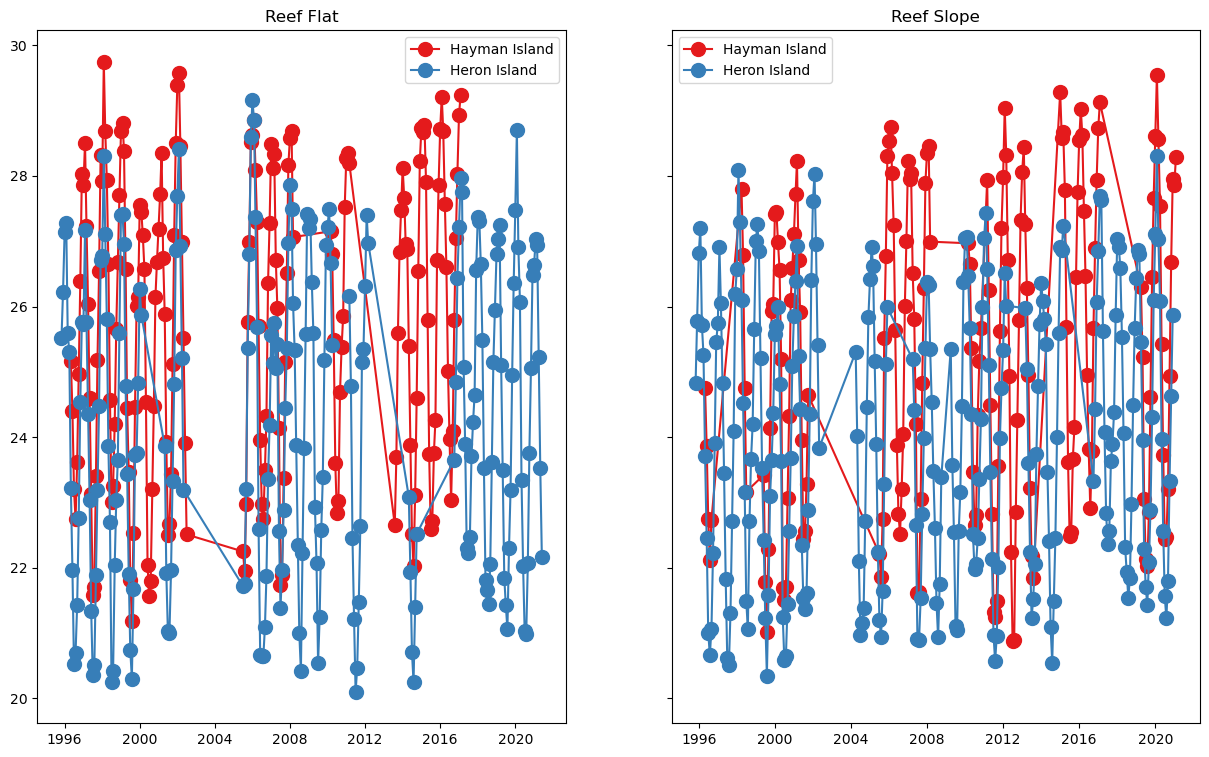

In [124]:
# We group our data by site, colours, and deployment location
groups = sites_temp.groupby(['site', 'colours', 'deployment_location'])

# We select a color map for our plots
cmap = cmaps['Set1']

# We initialise the figure and axes. We also define the size of the figure.
# Axes refer to the subplots in the figure (1 row and 2 columns). They will share the y axis
fig, ax = plt.subplots(1, 2, figsize = (15, 9), sharey = True)

# Now we use our groups to plot the data
# Element here has the categories of the groupby object (site, colours, and deployment location)
# Group has the subset dataframes for each category
for element, group in groups:
    # If the deployment location is reef flat, we plot the data in the first subplot
    if 'flat' in element[2]:
        # Plotting dates in x axis and mean temperature in y axis
        ax[0].plot(group['date_mean'], group['qc_val'], marker = 'o', ms = 10, 
             # We use the site name as the label for each line and the color will change based on the colour column
             label = f'{element[0]}', color = cmap(element[1]))
        # Title for subplot
        ax[0].set_title('Reef Flat')
        # Adding legend
        ax[0].legend()
    # In all other cases, we plot the data in the second subplot
    else:
        #As above
        ax[1].plot(group['date_mean'], group['qc_val'], marker = 'o', ms = 10, 
             label = f'{element[0]}', color = cmap(element[1]))
        ax[1].set_title('Reef Slope')
        ax[1].legend()



If you would like to save the figure, you can use the `savefig` method, as follows: `plt.savefig(file_name)`. Here `file_name` can contain a path to a directory and a file name with the extension of the file type you would like to save the figure as. For example, `plt.savefig('figures/temperature_timeseries.png')` will save the figure in a directory called `figures` and the file name will be `temperature_timeseries.png`.  
  
If you would like to save the data frame, you can use the `to_csv` method, as follows: `sites_temp.to_csv(file_name)`.  
  
That is the end of this notebook. We have demonstrated how to extract data from the AIMS Temperature Logger Monitoring Program dataset and how to plot monthly means for two sites of interest.  